In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque
import random
from datetime import datetime
import json

# Add src directory
sys.path.append(os.path.join(os.getcwd(), 'src'))

# Use Pygame-based environment (much faster than browser!)
from dino_pygame_env import DinoPygameEnv

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Device: {device}")
print(f"\n🎮 Using LOCAL Pygame environment (no browser needed!)")
print(f"   Credit: Chrome-Dino-Runner by dhhruv")

PyTorch: 2.5.1+cu121
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Device: cuda

🎮 Using LOCAL Pygame environment (no browser needed!)
   Credit: Chrome-Dino-Runner by dhhruv


c:\Users\IC1807\anaconda3\envs\DINO_TF\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## 2. Simple DQN Network (Dense Layers Only - No CNN!)

In [2]:
class SimpleDQN(nn.Module):
    """
    Simple Dense network for state-based input.
    
    Architecture:
    - Input: 8 features (obstacle distance, dino position, speed, etc.)
    - Hidden: 128 → 64 neurons with ReLU
    - Output: 3 Q-values (run, jump, duck)
    
    This is MUCH simpler and faster than CNN!
    """
    
    def __init__(self, input_size=8, action_size=3, hidden_size=128):
        super(SimpleDQN, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQNAgent:
    """
    DQN Agent for state-based learning.
    3 actions: RUN (0), JUMP (1), DUCK (2)
    """
    
    def __init__(
        self,
        state_size=8,
        action_size=3,  # RUN, JUMP, DUCK
        learning_rate=0.001,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay_steps=50000,
        batch_size=64,
        memory_size=50000,
        target_update_freq=500
    ):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.device = device
        
        # Exploration
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_rate = (epsilon_start - epsilon_end) / epsilon_decay_steps
        
        # Training
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.steps = 0
        
        # Memory
        self.memory = deque(maxlen=memory_size)
        
        # Networks
        self.q_network = SimpleDQN(state_size, action_size).to(self.device)
        self.target_network = SimpleDQN(state_size, action_size).to(self.device)
        self.update_target_network()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        
        print("✓ Simple DQN Agent initialized")
        print(f"  State size: {state_size} features")
        print(f"  Action size: {action_size} (RUN=0, JUMP=1)")
        print(f"  Device: {self.device}")
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state, training=True):
        is_random = training and np.random.rand() <= self.epsilon
        if is_random:
            action = np.random.randint(self.action_size)
            return action, True  # Return action and is_random flag
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax().item(), False  # Return action and is_random flag
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0.0
        
        batch = random.sample(self.memory, self.batch_size)
        states = torch.FloatTensor(np.array([exp[0] for exp in batch])).to(self.device)
        actions = torch.LongTensor([exp[1] for exp in batch]).to(self.device)
        rewards = torch.FloatTensor([exp[2] for exp in batch]).to(self.device)
        next_states = torch.FloatTensor(np.array([exp[3] for exp in batch])).to(self.device)
        dones = torch.FloatTensor([exp[4] for exp in batch]).to(self.device)
        
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        loss = self.loss_fn(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_rate
            self.epsilon = max(self.epsilon_end, self.epsilon)
    
    def save(self, filepath):
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'steps': self.steps,
            'epsilon': self.epsilon
        }, filepath)
        print(f"✓ Model saved: {filepath}")
    
    def load(self, filepath):
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.steps = checkpoint.get('steps', 0)
        self.epsilon = checkpoint.get('epsilon', self.epsilon_end)
        print(f"✓ Model loaded: {filepath}")

## 3. Training Configuration

In [3]:
CONFIG = {
    'num_episodes': 500,
    'max_steps_per_episode': 10000,
    
    # DQN parameters (optimized for state-based)
    'learning_rate': 0.0005,  # Slightly lower for stability
    'gamma': 0.95,  # Lower gamma - focus on immediate rewards
    'batch_size': 32,  # Smaller batch for faster updates
    'memory_size': 50000,
    'target_update_freq': 1000,  # Less frequent target updates
    
    # Exploration - SLOWER decay to explore more
    'epsilon_start': 1.0,
    'epsilon_end': 0.05,  # Keep some exploration
    'epsilon_decay_steps': 100000,  # Much slower decay!
    
    # Logging
    'log_interval': 10,
    'save_interval': 50,
}

os.makedirs('models_state', exist_ok=True)
os.makedirs('logs_state', exist_ok=True)
os.makedirs('plots_state', exist_ok=True)

print("📋 Config (UPDATED - anti-jump-spam):")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

📋 Config (UPDATED - anti-jump-spam):
  num_episodes: 500
  max_steps_per_episode: 10000
  learning_rate: 0.0005
  gamma: 0.95
  batch_size: 32
  memory_size: 50000
  target_update_freq: 1000
  epsilon_start: 1.0
  epsilon_end: 0.05
  epsilon_decay_steps: 100000
  log_interval: 10
  save_interval: 50


## 4. Initialize Environment and Agent

In [4]:
# Initialize agent (environment will be created as multi-window later)
print("🤖 Initializing DQN agent with 3 actions (RUN, JUMP, DUCK)...")
agent = DQNAgent(
    state_size=8,
    action_size=3,  # RUN, JUMP, DUCK
    learning_rate=CONFIG['learning_rate'],
    gamma=CONFIG['gamma'],
    epsilon_start=CONFIG['epsilon_start'],
    epsilon_end=CONFIG['epsilon_end'],
    epsilon_decay_steps=CONFIG['epsilon_decay_steps'],
    batch_size=CONFIG['batch_size'],
    memory_size=CONFIG['memory_size'],
    target_update_freq=CONFIG['target_update_freq']
)

# Check network size
params = sum(p.numel() for p in agent.q_network.parameters())
print(f"\n📊 Network has {params:,} parameters")
print(f"   (vs ~1-2 million for CNN version!)")
print("\n✅ Agent ready! Run next cells to start 4-window training.")

🤖 Initializing DQN agent with 3 actions (RUN, JUMP, DUCK)...
✓ Simple DQN Agent initialized
  State size: 8 features
  Action size: 3 (RUN=0, JUMP=1)
  Device: cuda

📊 Network has 9,603 parameters
   (vs ~1-2 million for CNN version!)

✅ Agent ready! Run next cells to start 4-window training.
✓ Simple DQN Agent initialized
  State size: 8 features
  Action size: 3 (RUN=0, JUMP=1)
  Device: cuda

📊 Network has 9,603 parameters
   (vs ~1-2 million for CNN version!)

✅ Agent ready! Run next cells to start 4-window training.


## 4.8. Resume Training from Best Model (Optional)

Run this cell to load the best saved model and continue training from where you left off!

In [5]:
# Resume from best model (Optional - run this before training to continue)
import glob

RESUME_TRAINING = False  # Set to False for fresh start (required after changing action count!)

if RESUME_TRAINING:
    # Find best available model
    model_files = glob.glob('models_state/*.pth')
    
    if model_files:
        # Priority: best_model > interrupted > latest checkpoint
        if os.path.exists('models_state/best_model.pth'):
            model_path = 'models_state/best_model.pth'
        elif os.path.exists('models_state/interrupted.pth'):
            model_path = 'models_state/interrupted.pth'
        else:
            # Get latest checkpoint
            checkpoints = [f for f in model_files if 'checkpoint' in f]
            if checkpoints:
                model_path = max(checkpoints, key=os.path.getmtime)
            else:
                model_path = max(model_files, key=os.path.getmtime)
        
        print(f"📂 Loading model: {model_path}")
        agent.load(model_path)
        print(f"   ε = {agent.epsilon:.4f}")
        print(f"   Steps = {agent.steps:,}")
        print(f"\n✅ Resuming training from saved state!")
    else:
        print("⚠ No saved models found. Starting fresh.")
        RESUME_TRAINING = False
else:
    print("🆕 Starting fresh training with 2 actions (RUN + JUMP only)")

🆕 Starting fresh training with 2 actions (RUN + JUMP only)


## 5. Pygame-Based Training (Much Faster!)

Training using the local Pygame Dino game - no browser needed!
Credit: Chrome-Dino-Runner by dhhruv (https://github.com/dhhruv/Chrome-Dino-Runner)

In [6]:
# Pygame-Based Training - Single Window (FAST!)
from dino_pygame_env import DinoPygameEnv

# Close old environment if exists
try:
    env.close()
except:
    pass

# Get current attempt number
attempt_file = 'logs_state/attempt_number.txt'
if os.path.exists(attempt_file):
    with open(attempt_file, 'r') as f:
        ATTEMPT_NUMBER = int(f.read().strip()) + 1
else:
    ATTEMPT_NUMBER = 1

# Save new attempt number
with open(attempt_file, 'w') as f:
    f.write(str(ATTEMPT_NUMBER))

print(f"🎯 TRAINING ATTEMPT #{ATTEMPT_NUMBER}")
print("="*50)

# Initialize Pygame environment
print(f"\n🎮 Initializing Pygame Dino Environment...")
env = DinoPygameEnv(render_mode='human')

print(f"\n✅ Pygame environment ready!")
print(f"   This is MUCH faster than browser-based training!")
print(f"   Credit: Chrome-Dino-Runner by dhhruv")

🎯 TRAINING ATTEMPT #15

🎮 Initializing Pygame Dino Environment...

✅ Pygame environment ready!
   This is MUCH faster than browser-based training!
   Credit: Chrome-Dino-Runner by dhhruv

✅ Pygame environment ready!
   This is MUCH faster than browser-based training!
   Credit: Chrome-Dino-Runner by dhhruv


In [7]:
# TRAINING LOOP - Pygame Environment (FAST!)
episode_rewards = []
episode_scores = []
episode_losses = []
epsilon_history = []

# Load previous best score if resuming
if RESUME_TRAINING and os.path.exists('logs_state/best_score.txt'):
    with open('logs_state/best_score.txt', 'r') as f:
        best_score = int(f.read().strip())
    print(f"📈 Resuming with previous best score: {best_score}")
else:
    best_score = 0
best_reward = float('-inf')

# Progress file for this attempt
progress_file = f'logs_state/attempt_{ATTEMPT_NUMBER}_progress.txt'
with open(progress_file, 'w') as f:
    f.write(f"Training Attempt #{ATTEMPT_NUMBER}\n")
    f.write(f"Environment: Pygame (local)\n")
    f.write(f"Resume: {RESUME_TRAINING}\n")
    f.write(f"Started: {datetime.now()}\n")
    f.write(f"Initial ε: {agent.epsilon:.4f}\n")
    f.write(f"Initial steps: {agent.steps:,}\n")
    f.write("="*80 + "\n\n")

print(f"\n🚀 Starting Pygame training - Attempt #{ATTEMPT_NUMBER}")
print(f"   ε: {agent.epsilon:.4f} | Steps: {agent.steps:,}")
print("="*80)

try:
    for episode in range(CONFIG['num_episodes']):
        # Reset environment
        state, info = env.reset()
        
        episode_reward = 0
        episode_loss = []
        steps = 0
        
        # Episode loop
        while steps < CONFIG['max_steps_per_episode']:
            # Get action from agent
            action, is_random = agent.act(state, training=True)
            
            # Update debug display on environment
            env.debug_epsilon = agent.epsilon
            env.debug_is_random = is_random
            env.last_action = action
            
            # Step environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Store experience
            agent.remember(state, action, reward, next_state, done)
            
            # Train on GPU
            loss = agent.replay()
            if loss > 0:
                episode_loss.append(loss)
            
            episode_reward += reward
            agent.steps += 1
            
            # Update target network
            if agent.steps % agent.target_update_freq == 0:
                agent.update_target_network()
            
            # Decay epsilon
            agent.update_epsilon()
            
            state = next_state
            steps += 1
            
            # Progress update
            if steps % 100 == 0:
                print(f"  Attempt #{ATTEMPT_NUMBER} | Ep {episode+1} | Step {steps} | Score {info['score']} | ε {agent.epsilon:.3f}", end='\r')
            
            if done:
                break
        
        print(" " * 120, end='\r')
        
        # Episode metrics
        score = info['score']
        avg_loss = np.mean(episode_loss) if episode_loss else 0
        
        episode_rewards.append(episode_reward)
        episode_scores.append(score)
        episode_losses.append(avg_loss)
        epsilon_history.append(agent.epsilon)
        
        # Update best
        is_new_best = False
        if score > best_score:
            best_score = int(score)
            agent.save('models_state/best_model.pth')
            # Save best score for resume
            with open('logs_state/best_score.txt', 'w') as f:
                f.write(str(best_score))
            is_new_best = True
        
        if episode_reward > best_reward:
            best_reward = episode_reward
        
        # Log
        with open(progress_file, 'a') as f:
            f.write(f"Ep {episode+1}: Score={score}, Reward={episode_reward:.2f}, ε={agent.epsilon:.4f}")
            if is_new_best:
                f.write(" 🏆")
            f.write("\n")
        
        # Print
        if (episode + 1) % CONFIG['log_interval'] == 0:
            print(f"\n📊 Attempt #{ATTEMPT_NUMBER} | Episode {episode+1}/{CONFIG['num_episodes']}")
            print(f"  Avg Score: {np.mean(episode_scores[-10:]):.0f} | Best: {best_score}")
            print(f"  Avg Reward: {np.mean(episode_rewards[-10:]):.2f}")
            print(f"  Loss: {avg_loss:.4f} | ε: {agent.epsilon:.3f}")
            print(f"  Memory: {len(agent.memory)}/{CONFIG['memory_size']}")
            print(f"  Total steps: {agent.steps:,}")
            print("-" * 80)
        else:
            best_str = " 🏆 NEW BEST!" if is_new_best else ""
            print(f"Ep {episode+1}: Score={score}{best_str}")
        
        # Checkpoint
        if (episode + 1) % CONFIG['save_interval'] == 0:
            agent.save(f'models_state/checkpoint_attempt{ATTEMPT_NUMBER}_ep{episode+1}.pth')
            print(f"💾 Checkpoint saved")

except KeyboardInterrupt:
    print(f"\n⚠ Attempt #{ATTEMPT_NUMBER} interrupted")
    agent.save('models_state/interrupted.pth')
    print("💾 Model saved to interrupted.pth - run again to resume!")

finally:
    print(f"\n🏁 Attempt #{ATTEMPT_NUMBER} complete!")
    print(f"  Best score: {best_score}")
    print(f"  Best reward: {best_reward:.2f}")
    print(f"  Total steps: {agent.steps:,}")
    env.close()
    print(f"\n💡 To resume: Set RESUME_TRAINING = True and run again!")


🚀 Starting Pygame training - Attempt #15
   ε: 1.0000 | Steps: 0
✓ Model saved: models_state/best_model.pth                                                                              
Ep 1: Score=132 🏆 NEW BEST!
✓ Model saved: models_state/best_model.pth                                                                              
Ep 1: Score=132 🏆 NEW BEST!
Ep 2: Score=129                                                                                                         
Ep 2: Score=129                                                                                                         
Ep 3: Score=131                                                                                                         
Ep 3: Score=131                                                                                                         
Ep 4: Score=116                                                                                                         
Ep 4: Score=116                

## 6. Visualize Training

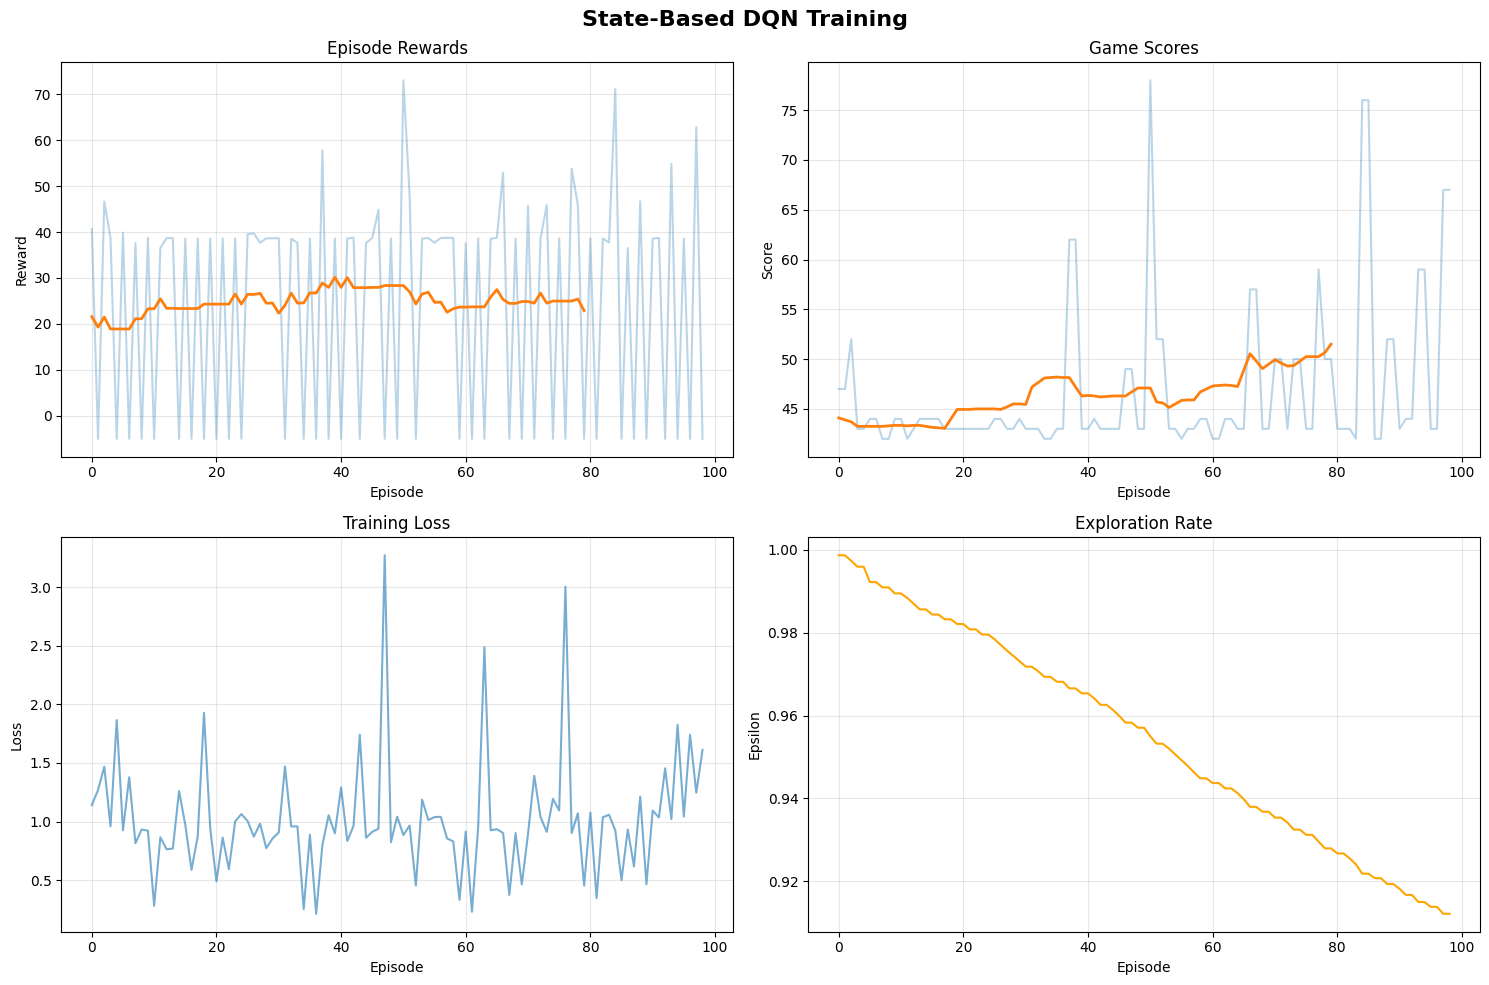

✓ Plots saved


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('State-Based DQN Training', fontsize=16, fontweight='bold')

# Rewards
axes[0, 0].plot(episode_rewards, alpha=0.3)
if len(episode_rewards) > 20:
    axes[0, 0].plot(np.convolve(episode_rewards, np.ones(20)/20, mode='valid'), linewidth=2)
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True, alpha=0.3)

# Scores
axes[0, 1].plot(episode_scores, alpha=0.3)
if len(episode_scores) > 20:
    axes[0, 1].plot(np.convolve(episode_scores, np.ones(20)/20, mode='valid'), linewidth=2)
axes[0, 1].set_title('Game Scores')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Score')
axes[0, 1].grid(True, alpha=0.3)

# Loss
axes[1, 0].plot(episode_losses, alpha=0.6)
axes[1, 0].set_title('Training Loss')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)

# Epsilon
axes[1, 1].plot(epsilon_history, color='orange')
axes[1, 1].set_title('Exploration Rate')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots_state/training_metrics.png', dpi=150)
plt.show()

print("✓ Plots saved")

## 7. Test Trained Agent

In [ ]:
print("🎮 Testing agent...\n")

# Create fresh environment for testing
test_env = DinoPygameEnv(render_mode='human')

agent.load('models_state/best_model.pth')
agent.epsilon = 0.0  # No exploration

test_scores = []
test_rewards = []

for ep in range(5):
    state, info = test_env.reset()
    episode_reward = 0
    steps = 0
    
    while steps < 10000:
        action = agent.act(state, training=False)
        state, reward, terminated, truncated, info = test_env.step(action)
        episode_reward += reward
        steps += 1
        
        if terminated or truncated:
            break
    
    test_scores.append(info['score'])
    test_rewards.append(episode_reward)
    print(f"Test {ep+1}: Score={info['score']:.0f}, Reward={episode_reward:.2f}, Steps={steps}")

print(f"\n📊 Test Results:")
print(f"  Avg Score: {np.mean(test_scores):.0f} ± {np.std(test_scores):.0f}")
print(f"  Best: {max(test_scores):.0f}")
print(f"  Worst: {min(test_scores):.0f}")

test_env.close()